In [1]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import theano.tensor as tt
import theano
from theano import shared
floatX = theano.config.floatX
import pandas as pd
from matplotlib import gridspec
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import scale
from sklearn import svm

import scipy as sp
from theano.compile.ops import as_op
from numpy import arange, array, empty
from Plot_raw import *
from DataSplit import *
from DataSplitOne import *
from RMSE import *
%matplotlib inline

D:\Softwares\Python\Python_Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
plt.style.use('default')
font1 ={'family': 'times new roman', 'weight':'light', 'size': 12}  
# font2 ={'family': 'Arial', 'weight':'normal', 'size': 12}  
def Plot_XZ(elec_year, elec_faults, Savefig):
# 画出原始图
    Company_names = ['Xizang', 'Xinjiang', 'Heilongjiang']
    k = np.array([0, 41, 83])
    j= 0
    # j, k1 = 0, 6
    plt.figure(figsize=(4, 3), facecolor='w')

    ax = plt.subplot(1, 1, 1)
    for jx in range(7):
        ax.plot(elec_year[jx], elec_faults[jx], 'ko--', markersize=4, linewidth=1)
        # j = j+k1
    ax.set_xticklabels(['2016', '2010', '2011', '2012', '2013', '2014', '2015'], fontsize='small')
    ax.set_xlabel("time(year)", fontdict=font1)
    plt.ylabel("Failure rate(%)", fontdict=font1)
    plt.legend([Company_names[0]], loc='upper left', frameon=False, fontsize='small')
#     plt.grid()
    if Savefig == 1:
        plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\Picture\\1.svg', format='svg')
    plt.show()
    plt.figure(figsize=(4, 3), facecolor='w')

    ax = plt.subplot(1, 1, 1)
    for jx in range(7, 14, 1):
        ax.plot(elec_year[jx], elec_faults[jx], 'ko--', markersize=4, linewidth=1)
        # j = j+k1
    ax.set_xticklabels(['2016','2010', '2011', '2012', '2013', '2014', '2015'], fontsize='small')
    ax.set_xlabel("time(year)", fontdict=font1)
    plt.ylabel("Failure rate(%)", fontdict=font1)
    plt.legend([Company_names[1]], loc='upper left', frameon=False, fontsize='small')
#     plt.grid()
    if Savefig == 1:
        plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\Picture\\2.svg', format='svg')
    plt.show()
    
    plt.figure(figsize=(4, 3), facecolor='w')
    ax = plt.subplot(1, 1, 1)
    for jx in range(14, 21, 1):
        ax.plot(elec_year[jx], elec_faults[jx], 'ko--', markersize=4, linewidth=1)
        # j = j+k1
    ax.set_xticklabels(['2016','2010', '2011', '2012', '2013', '2014', '2015'], fontsize='small')
    ax.set_xlabel("time(year)", fontdict=font1)
    plt.ylabel("Failure rate(%)", fontdict=font1)
    plt.legend([Company_names[2]], loc='upper left', frameon=False, fontsize='small')
#     leg = plt.legend()
#     leg.get_frame().set_linewidth(0.0)
    
#     plt.grid()
    if Savefig == 1:
        plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\Picture\\3.svg', format='svg')
    plt.show()
    return 0

[0. 0. 0. 0. 2. 1. 0. 0. 0. 1. 3. 2. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 1. 1. 2. 0. 0. 0. 0. 3. 3. 0. 0. 0. 3. 4. 3. 0. 0. 0. 0. 0. 0.
 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 5. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1.
 0. 0. 1. 1. 1. 1. 0. 0. 1. 2. 2. 2. 0. 0. 1. 1. 1. 1. 0. 0. 2. 1. 3. 3.
 0. 0. 1. 2. 2. 2.]


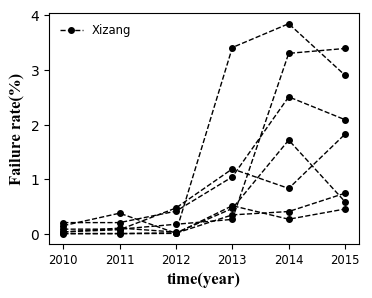

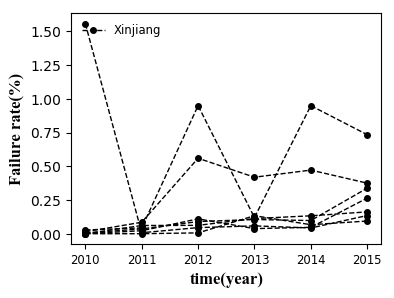

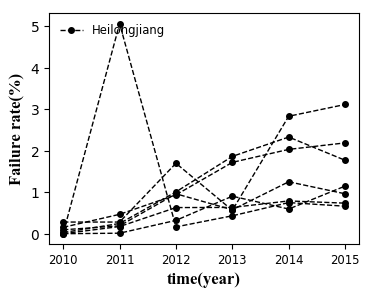

In [3]:
np.set_printoptions(precision=0, suppress=True)
Savefig = 0 # 控制图形显示存储

elec_data = pd.read_csv('XZmulti_6.csv')

# 计算同一公司产品测试地点数目：
companies_num = elec_data.counts.unique()
companies = len(companies_num)  # companies=7， 共7个测试地点
company_lookup = dict(zip(companies_num, range(len(companies_num))))
company = elec_data['company_code'] = elec_data.counts.replace(company_lookup).values  # 加一行数据在XZsingal文件中
# companys = elec_data.counts.values - 1 # 这一句以上面两行功能相同

# 计算不同公司数目
company_ABC = elec_data.company.unique()
companiesABC = len(company_ABC)  # companies=7， 共7个测试地点
company_lookup_ABC = dict(zip(company_ABC, range(len(company_ABC))))
companyABC = elec_data['company_ABC'] = elec_data.company.replace(company_lookup_ABC).values  # 加一行数据在XZsingal文件中
# companys = elec_data.counts.values - 1 # 这一句以上面两行功能相同
# elec_count = elec_data.counts.values

# 给所有特征因素加上高斯噪声
SNR = np.random.normal(0, 2, size=[len(elec_data.Year.values), 4])

# #特征因素分析
elec_tem = elec_data.Tem.values + SNR[:, 0] # 观测温度值x2
elec_tem1 = (elec_tem - np.mean(elec_tem)) / np.std(elec_tem)
elec_hPa = elec_data.hPa.values + SNR[:, 1]  # 观测压强x3
elec_hPa1 = (elec_hPa - np.mean(elec_hPa)) / np.std(elec_hPa)
elec_RH = elec_data.RH.values + SNR[:, 2] # 观测压强x3
elec_RH1 = (elec_RH - np.mean(elec_RH)) / np.std(elec_RH)
elec_Lux = elec_data.Lux.values + SNR[:, 3] # 观测压强x3
elec_Lux1 = (elec_Lux - np.mean(elec_Lux)) / np.std(elec_Lux)


# 计算观测时间，温度，光照等环境条件
elec_year = elec_data.Year.values  # 观测时间值x1
elec_year1 = (elec_year - np.mean(elec_year)) / np.std(elec_year)
data_cs_year = elec_year
# data_cs_year[42:45] = 12
# print(data_cs_year)

elec_Pca = np.vstack((elec_tem1, elec_hPa1, elec_RH1, elec_Lux1)).T   # 特征数据合并为一个数组
# elec_Pca2 = np.vstack((elec_tem, elec_hPa, elec_RH, elec_Lux)).T   # 特征数据合并为一个数组
# np.savetxt('XZ_nomean.csv', elec_Pca2, delimiter = ',')
# =============================================================================================
# # PCA特征降维，减少相关性，有两种方法，一种是自带函数，一种是网上程序，下面注释为网上程序
# x, z= pcaa(elec_Pca);  XX = np.array(x); ZZ = np.array(z)
# 将温度等4个特征降维变成2个特征，贡献率为99%以上，满足信息要求; 转换后的特征经过模型后能否还原
# =============================================================================================
# #白化，使得每个特征具有相同的方差，减少数据相关性，n_components：控制特征量个数
pca = PCA(n_components=2)
pca.fit(elec_Pca)
# 将数据X转换成降维后的数据。当模型训练好后，对于新输入的数据，都可以用transform方法来降维。
elec_Pca1 = pca.transform(elec_Pca)
elec_Pca1 = np.array(elec_Pca1)

elec_Pca_char1 = elec_Pca1[:, 0] # 降维特征1
elec_Pca_char2 = elec_Pca1[:, 1] # 降维特征2
# elec_Pca_char1 = np.loadtxt('elec_Pca_char1.csv',delimiter = ',')
# elec_Pca_char2 = np.loadtxt('elec_Pca_char2.csv',delimiter = ',')
# elec_Pca_char3 = elec_Pca1[:, 2] # 降维特征2
# print(elec_Pca_char1)
elec_data.Fault.values[48] =1200
elec_data.Fault.values[85] =700
# 计算故障率大小：故障数目/总测量数，作为模型Y值，放大100倍以增加实际效果，结果中要缩小100倍
elec_faults = 100 * (elec_data.Fault.values / elec_data.Nums.values)  # 数组形式,计算故障率大小
elec_faults1 = (elec_faults - np.mean(elec_faults)) / np.std(elec_faults)
# elec_faults[25] = 3
# elec_faults[39] = 5
# elec_faults[53] = 3.8
print(elec_faults)
# 将故障率以6组一行形式组成数组,变成：21*6
elec_faults2 = np.array([elec_faults[i*6:(i+1)*6] for i in np.arange(21)])
elec_year2 = np.array([elec_year[i*6:(i+1)*6] for i in np.arange(21)])
elec_char1 = np.array([elec_Pca_char1[i*6:(i+1)*6] for i in np.arange(21)])
elec_char2 = np.array([elec_Pca_char2[i*6:(i+1)*6] for i in np.arange(21)])
companyABC2 = np.array([companyABC[i*6:(i+1)*6] for i in np.arange(21)])

# 共享变量设置
xs_char1 = shared(np.asarray(elec_Pca_char1))
xs_char2 = shared(np.asarray(elec_Pca_char2))

ys_faults = shared(np.asarray(elec_faults))
xs_year = shared(np.asarray(data_cs_year))
Num_shared = shared(np.asarray(companyABC))
# 画图
Plot_XZ(elec_year2, elec_faults2, Savefig)

def logit(x):
    return 1/(1+np.exp(-x))
def tlogit(x):
    return 1/(1+tt.exp(-x))
def Phi(x):
    # probit transform
    return 0.5 + 0.5 * pm.math.erf(x/pm.math.sqrt(2))

In [4]:
# 应用偏最小二乘PLS来进行仿真
from sklearn.cross_decomposition import PLSRegression
elec_year1 = (elec_year - np.mean(elec_year))
elec_faults_Mean = np.mean(elec_faults)
elec_faults1 = (elec_faults - elec_faults_Mean)
print(elec_faults_Mean)
# 实验证明，不管原始输入是否均值化，输出都是一样的
# elec_tem2 = elec_tem - np.mean(elec_tem)
# elec_hPa2 = elec_hPa - np.mean(elec_hPa)
# elec_RH2 = elec_RH - np.mean(elec_RH)
# elec_Lux2 = elec_Lux - np.mean(elec_Lux)

X_PLSR = np.vstack((elec_year1, elec_tem, elec_hPa, elec_RH, elec_Lux)).T   # 特征数据合并为一个数组
# X_PLSR = np.vstack((elec_year1, elec_Pca_char1, elec_Pca_char2)).T   # 特征数据合并为一个数组
# print(X_PLSR)
X_PLSR_XZ = X_PLSR[:42, :]
X_PLSR_XJ = X_PLSR[42:84, :]
X_PLSR_HLJ = X_PLSR[84:, :]

Y_PLSR = elec_faults1
Y_PLSR_XZ = Y_PLSR[:42]
Y_PLSR_XJ = Y_PLSR[42:84]
Y_PLSR_HLJ = Y_PLSR[84:]
# print(Y_PLSR_XZ)


pls_XZ = PLSRegression(n_components=3)
pls_XZ.fit(X_PLSR_XZ, Y_PLSR_XZ)
# X_train_r, Y_train_r = pls_XZ.transform(X_PLSR_XZ, Y_PLSR_XZ)
# PLSRegression(copy=True, max_iter=500, n_components=2, scale=True, tol=1e-06)
Y_PLSpred_XZ = pls_XZ.predict(X_PLSR_XZ)
Y_PLSpred_XZ =  np.vstack((Y_PLSpred_XZ)).T[0]
# print(X_train_r)
print(Y_PLSpred_XZ)

pls_XJ = PLSRegression(n_components=3)
pls_XJ.fit(X_PLSR_XJ, Y_PLSR_XJ)
# X_train_r, Y_train_r = pls_XZ.transform(X_PLSR_XZ, Y_PLSR_XZ)
# PLSRegression(copy=True, max_iter=500, n_components=2, scale=True, tol=1e-06)
Y_PLSpred_XJ = pls_XJ.predict(X_PLSR_XJ)
Y_PLSpred_XJ =  np.vstack((Y_PLSpred_XJ).T)[0]
# print(X_train_r)
# print(Y_PLSpred_XJ)


pls_HLJ = PLSRegression(n_components=3)
pls_HLJ.fit(X_PLSR_HLJ, Y_PLSR_HLJ)
# X_train_r, Y_train_r = pls_XZ.transform(X_PLSR_HLJ, Y_PLSR_HLJ)
# PLSRegression(copy=True, max_iter=500, n_components=2, scale=True, tol=1e-06)
Y_PLSpred_HLJ = pls_HLJ.predict(X_PLSR_HLJ)
Y_PLSpred_HLJ =  np.vstack((Y_PLSpred_HLJ).T)[0]
# print(Y_PLSpred_HLJ)
# print(Y_train_r)

Y_PLSpred = np.vstack((Y_PLSpred_XZ, Y_PLSpred_XJ, Y_PLSpred_HLJ))# Pls预测值
Y_PLSpred_Target = np.vstack((Y_PLSR_XZ, Y_PLSR_XJ, Y_PLSR_HLJ)) # 目标值
# print(Y_PLSpred)
# print(Y_PLSpred[0])

aaa = pls_HLJ.get_params(deep=True) # 获取参数
print(aaa)

0.667498982160029
[-0. -0. -0.  0.  1.  1. -0. -0.  0.  0.  1.  1. -1. -0.  0.  0.  0.  0.
 -1. -0.  0.  0.  0.  1. -0. -0.  0.  0.  1.  1. -0. -0. -0.  0.  1.  1.
 -0. -0.  0.  0.  1.  1.]
{'copy': True, 'max_iter': 500, 'n_components': 3, 'scale': True, 'tol': 1e-06}


In [5]:
# 将预测值转化为均值形式
AAA = np.array([Y_PLSpred_XZ[i*6:(i+1)*6] for i in np.arange(7)])
BBB = np.array([Y_PLSpred_XJ[i*6:(i+1)*6] for i in np.arange(7)])
CCC = np.array([Y_PLSpred_HLJ[i*6:(i+1)*6] for i in np.arange(7)])
XZ_mean = AAA[:].mean(axis=0)
XJ_mean = BBB[:].mean(axis=0)
HLJ_mean = CCC[:].mean(axis=0)
Y_PLSpred_MEAN = np.vstack((XZ_mean, XJ_mean, HLJ_mean))# Pls预测值
# print(XZ_mean)
# print(HLJ_mean)
Y_PLSpred_MEAN  = Y_PLSpred_MEAN + elec_faults_Mean
print(Y_PLSpred_MEAN)
print('\n')
# 计算MSE 时用均值计算
for i in np.arange(7):
    Y_PLSpred[0,i*6:(i+1)*6] = XZ_mean
    Y_PLSpred[1,i*6:(i+1)*6] = XJ_mean
    Y_PLSpred[2,i*6:(i+1)*6] = HLJ_mean
# print(Y_PLSpred)

# 计算均方误差
RmseTrain_all_PRLS = RMSE(elec_faults, Y_PLSpred_MEAN, Len_One=6, Zoom_factor=1)
print(RmseTrain_all_PRLS)

# np.savetxt('Y_PLSpred_MEAN.csv', Y_PLSpred_MEAN, delimiter = ',')

[[0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1.]]


Rmse Mean is A、B、C :
{0: 0.806999697637788, 1: 0.2601136226106308, 2: 0.8055756520013155}


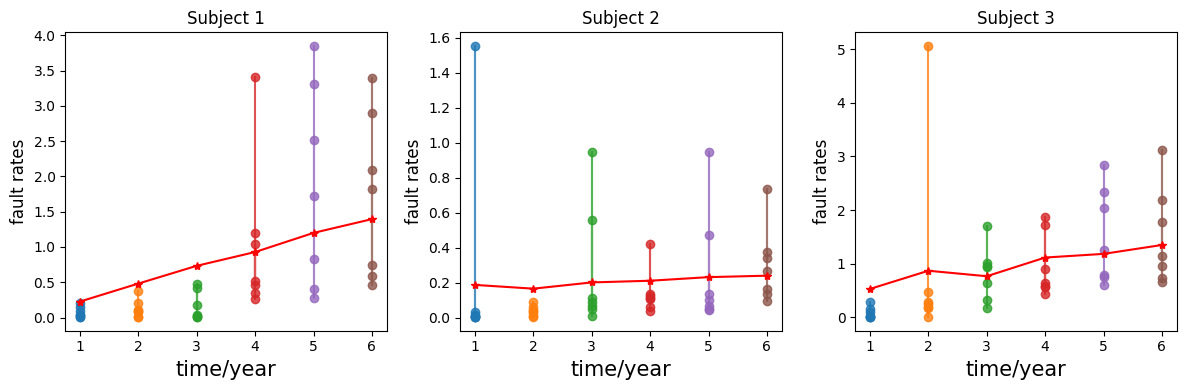

In [6]:
fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 3)
xipred = np.array(np.arange(6) + 1)

for ip in np.arange(3):
    ax = plt.subplot(gs[ip])
    xp = elec_year2[ip * 7:(ip + 1) * 7, :]  # 原始数据
    yp = elec_faults2[ip * 7:(ip + 1) * 7, :]
    ax.plot(xp, yp, marker='o', alpha=.8)

    yipred_yplot = np.array(Y_PLSpred_MEAN[ip]) #补上均值化的值

    ax.plot(xipred, yipred_yplot, 'k*-', color='r')
    plt.xlabel('time/year', fontsize=15)
    plt.ylabel('fault rates', fontsize=12)
    plt.title('Subject %s' % (ip + 1))

plt.tight_layout()
plt.show()

In [7]:
# 第七年数据测试，读取测试数据集特征,
data_cs = pd.read_csv('XZ_CS.csv')
SNR_cs = np.random.normal(0, 2, size=[len(data_cs.Tem.values), 4])
datax_cs = np.array(data_cs)[:,0:4] + SNR_cs # 针对特征添加噪声

data_cs_year = data_cs.Year.values # 测试数据时间

meanVal = np.mean(datax_cs, axis=0)  # 按列求均值，即求各个特征的均值
newData_mean = datax_cs - meanVal
StdVal  = np.std(datax_cs, axis=0)
newData_std = newData_mean/StdVal


pca = PCA(n_components=2)
pca.fit(newData_std)
Pca_cs = pca.transform(newData_std) # 测试数据PCA特征值，直接调用即可，但是之调用这条也会出问题
Pca_cs_char1 = Pca_cs[:, 0]
Pca_cs_char2 = Pca_cs[:, 1]
print(data_cs_year)
print(len(data_cs_year))

[1 2 3 4 5 6 7 1 2 3 4 5 6 7 1 2 3 4 5 6 7 1 2 3 4 5 6 7 1 2 3 4 5 6 7 1 2
 3 4 5 6 7 1 2 3 4 5 6 7 1 2 3 4 5 6 7 1 2 3 4 5 6 7 1 2 3 4 5 6 7 1 2 3 4
 5 6 7 1 2 3 4 5 6 7 1 2 3 4 5 6 7 1 2 3 4 5 6 7 1 2 3 4 5 6 7 1 2 3 4 5 6
 7 1 2 3 4 5 6 7 1 2 3 4 5 6 7]
126


In [8]:
# 预测
PLSR_data_cs_year = (data_cs_year - np.mean(data_cs_year))

PLSR_Pred = np.vstack((PLSR_data_cs_year, data_cs.Tem.values, data_cs.hPa.values, data_cs.RH.values, data_cs.Lux.values)).T

Pred_PLSR_XZ = PLSR_Pred[:42, :]
Pred_PLSR_XJ = PLSR_Pred[42:84, :]
Pred_PLSR_HLJ = PLSR_Pred[84:, :]
# print(PLSR_Pred)


Pred_Plsr_XZ = pls_XZ.predict(Pred_PLSR_XZ)
Pred_Plsr_XZ = np.vstack((Y_PLSpred_XZ)).T[0]
print(Pred_Plsr_XZ)
Pred_PlsrXZ_Mean = np.array([Pred_Plsr_XZ[i*7:(i+1)*7] for i in np.arange(6)])
Pred_PlsrXZ_Mean1 = Pred_PlsrXZ_Mean.mean(axis=0) + elec_faults_Mean
print(Pred_PlsrXZ_Mean1)


Pred_Plsr_XJ = pls_XJ.predict(Pred_PLSR_XJ)
Pred_Plsr_XJ = np.vstack((Pred_Plsr_XJ)).T[0]
Pred_PlsrXJ_Mean = np.array([Pred_Plsr_XJ[i*7:(i+1)*7] for i in np.arange(6)])
Pred_PlsrXJ_Mean1 = Pred_PlsrXJ_Mean.mean(axis=0) + elec_faults_Mean
# print(X_train_r)
print(Pred_PlsrXJ_Mean1)

Pred_Plsr_HLJ = pls_HLJ.predict(Pred_PLSR_HLJ)
Pred_Plsr_HLJ = np.vstack((Pred_Plsr_HLJ)).T[0]
Pred_PlsrHLJ_Mean = np.array([Pred_Plsr_HLJ[i*7:(i+1)*7] for i in np.arange(6)])
Pred_PlsrHLJ_Mean1 = Pred_PlsrHLJ_Mean.mean(axis=0) + elec_faults_Mean
print(Pred_PlsrHLJ_Mean1)
# print(Y_train_r)

Pred_Y_PLSRpred = np.vstack((Pred_PlsrXZ_Mean1, Pred_PlsrXJ_Mean1, Pred_PlsrHLJ_Mean1))# Pls预测值
# Y_PLSpred_Target = np.vstack((Y_PLSR_XZ, Y_PLSR_XJ, Y_PLSR_HLJ)) # 目标值
print(Pred_Y_PLSRpred)
# np.savetxt('Pred_Y_PLSRpred.csv', Pred_Y_PLSRpred, delimiter = ',')

[-0. -0. -0.  0.  1.  1. -0. -0.  0.  0.  1.  1. -1. -0.  0.  0.  0.  0.
 -1. -0.  0.  0.  0.  1. -0. -0.  0.  0.  1.  1. -0. -0. -0.  0.  1.  1.
 -0. -0.  0.  0.  1.  1.]
[1. 1. 1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 1. 1. 1. 1. 1. 1.]
[[1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 1. 1. 1.]]


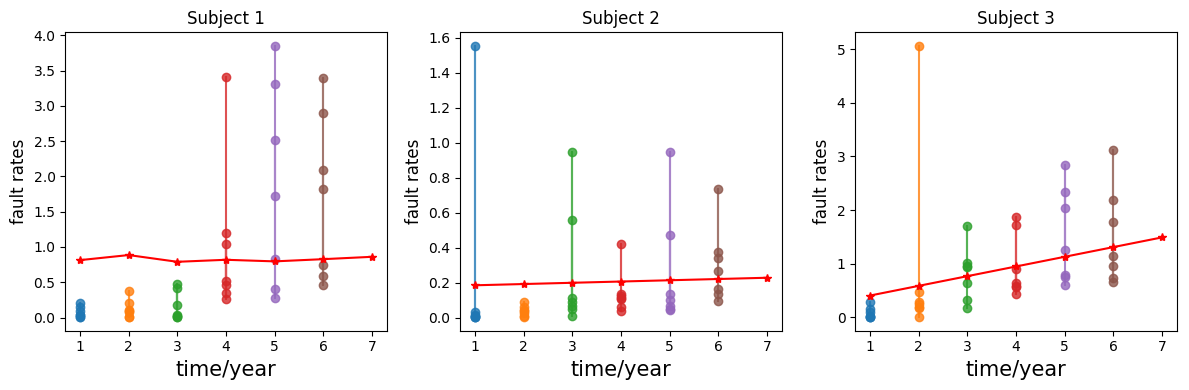

In [9]:
fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 3)
xipred = [1,2,3,4,5,6,7]

for ip in np.arange(3):
    ax = plt.subplot(gs[ip])
    xp = elec_year2[ip * 7:(ip + 1) * 7, :]  # 原始数据
    yp = elec_faults2[ip * 7:(ip + 1) * 7, :]
    ax.plot(xp, yp, marker='o', alpha=.8)

    yipred_yplot = np.array(Pred_Y_PLSRpred[ip]) #补上均值化的值

    ax.plot(xipred, yipred_yplot, 'k*-', color='r')
    plt.xlabel('time/year', fontsize=15)
    plt.ylabel('fault rates', fontsize=12)
    plt.title('Subject %s' % (ip + 1))

plt.tight_layout()
plt.show()

In [10]:
def RMSEfor_Pred1(Faults, FitValue, Len_One=7, Zoom_factor=100):
    Len_Faults = np.shape(Faults)
    Len_Fault = round(Len_Faults[0] / Len_One)  # round取整数，Len_Fault = 21/7 = 3

    Faults = Faults / Zoom_factor  # 还原数据
    FitValue = np.array(FitValue)
    FitValue = FitValue / Zoom_factor  # 还原数据

    Faults_Col = np.array([Faults[i * Len_One:(i + 1) * Len_One] for i in np.arange(Len_Fault)])  # 将输入数据排列好
    print(Faults_Col)
    Mean_Rmse = {}
    for i in np.arange(3):
        A = Rmse(Faults_Col[i], FitValue[i])  # 计算每组的均方根误差
        # print(Rmse_Value)
        Mean_Rmse[i] = A   # 计算每省的均方根误差
    # print(Mean_Rmse)
    print('Rmse Mean is A、B、C :')
    return Mean_Rmse

In [11]:
# 计算预测的均方差
Pred7year_PLSR = Pred_Y_PLSRpred[:,-1] #提取出ABC各省的均值预测值
print(Pred7year_PLSR)

Pred_Data = pd.read_csv('XZmulti_6_Only7Test.csv')
Pred_faults = 100 * (Pred_Data.Fault.values / Pred_Data.Nums.values)  # 数组形式,计算故障率大小

RmseTrain_PLSR = RMSEfor_Pred1(Pred_faults, Pred7year_PLSR)
print(RmseTrain_PLSR)

[1. 0. 1.]
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
Rmse Mean is A、B、C :
{0: 0.02151359351355779, 1: 0.0024047284920136053, 2: 0.0074829493108401895}


# 支持向量机
---

In [12]:
# 支持向量机
from sklearn import svm
from DataSplitOne import *

In [13]:
np.set_printoptions(precision=0, suppress=True)
Savefig = 0 # 控制图形显示存储
plt.style.use('default')
elec_data_SVM = pd.read_csv('XZmulti_6.csv')

# 计算同一公司产品测试地点数目：
companies_num_SVM = elec_data_SVM.counts.unique()
companies_SVM = len(companies_num_SVM)  # companies=7， 共7个测试地点
company_lookup_SVM = dict(zip(companies_num_SVM, range(len(companies_num_SVM))))
company_SVM = elec_data_SVM['company_code'] = elec_data_SVM.counts.replace(company_lookup_SVM).values  # 加一行数据在XZsingal文件中

# 计算不同公司数目
company_ABC_SVM = elec_data_SVM.company.unique()
companiesABC_SVM = len(company_ABC_SVM)  # companies=7， 共7个测试地点
company_lookup_ABC_SVM = dict(zip(company_ABC_SVM, range(len(company_ABC_SVM))))
companyABC_SVM = elec_data_SVM['company_ABC'] = elec_data_SVM.company.replace(company_lookup_ABC_SVM).values  # 加一行数据在XZsingal文件中
# 给所有特征因素加上高斯噪声
SNR_SVM = np.random.normal(0, 1, size=[len(elec_data_SVM.Year.values), 3])
SNR_SVM1 = np.random.normal(0, 1, size=[len(elec_data_SVM.Year.values), 1])

# #特征因素分析
elec_tem_SVM = elec_data_SVM.Tem.values  + SNR_SVM1[:, 0] # 观测温度值x2，温度不加噪声
elec_tem1_SVM = (elec_tem_SVM - np.mean(elec_tem_SVM)) / np.std(elec_tem_SVM)

elec_hPa_SVM = elec_data_SVM.hPa.values + SNR_SVM[:, 0]  # 观测压强x3
elec_hPa1_SVM = (elec_hPa_SVM - np.mean(elec_hPa_SVM)) / np.std(elec_hPa_SVM)
elec_RH_SVM = elec_data_SVM.RH.values + SNR_SVM[:, 1] # 观测压强x3
elec_RH1_SVM = (elec_RH_SVM - np.mean(elec_RH_SVM)) / np.std(elec_RH_SVM)
elec_Lux_SVM = elec_data_SVM.Lux.values + SNR_SVM[:, 2] # 观测压强x3
elec_Lux1_SVM = (elec_Lux_SVM - np.mean(elec_Lux_SVM)) / np.std(elec_Lux_SVM)

# 计算观测时间，温度，光照等环境条件
elec_year_SVM = elec_data_SVM.Year.values  # 观测时间值x1
elec_year1_SVM = (elec_year_SVM - np.mean(elec_year_SVM)) / np.std(elec_year_SVM)
# data_cs_year = np.ma.masked_values(elec_year, value=-999)
# print(data_cs_year)

elec_Pca2_SVM = np.vstack((elec_tem1_SVM, elec_hPa1_SVM, elec_RH1_SVM, elec_Lux1_SVM)).T   # 特征数据合并为一个数组
print(np.shape(elec_Pca2_SVM))

pca = PCA(n_components=2)
pca.fit(elec_Pca2_SVM)
# 将数据X转换成降维后的数据。当模型训练好后，对于新输入的数据，都可以用transform方法来降维。
elec_Pca1_SVM = pca.transform(elec_Pca2_SVM)
elec_Pca1_SVM = np.array(elec_Pca1_SVM)

elec_Pca_char1_SVM = elec_Pca1_SVM[:, 0] # 降维特征1
elec_Pca_char2_SVM = elec_Pca1_SVM[:, 1] # 降维特征2
print('\n')

elec_data.Fault.values[48] =1200
elec_data.Fault.values[85] =700
# 计算故障率大小：故障数目/总测量数，作为模型Y值，放大100倍以增加实际效果，结果中要缩小100倍
elec_faults_SVM = 100*(elec_data_SVM.Fault.values / elec_data_SVM.Nums.values)  # 数组形式,计算故障率大小

Mean_elec_faults = np.mean(elec_faults_SVM)
# elec_faults_Mean = elec_faults_SVM - Mean_elec_faults#最大值限定到[0,1]之间
# 将故障率以6组一行形式组成数组,变成：21*6
# print(elec_faults_Mean)

# Plot_raw(elec_year2, elec_faults2, Savefig)

X_SVM = scale(np.vstack((elec_year_SVM, elec_Pca_char1_SVM, elec_Pca_char2_SVM)).T)
X_SVM = X_SVM.astype(floatX)
Y_SVM = elec_faults_SVM #需要对Y进行均值化
Y_SVM = Y_SVM.astype(floatX)
# print(Y_SVM)
X_train, X_test, Y_train, Y_test = DataSplit(X_SVM, Y_SVM, test_size=.1)

# print(Y_train)
# print(X)
# print(Num_shared)
print(np.shape(X_test))

(126, 4)


[ 5 10 14]
(18, 3)


In [14]:
# SVM算法拟合效果，参数如下：
# SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='auto',
#     kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
X_SVM_XZ = X_SVM[:42, :]
X_SVM_XJ = X_SVM[42:84, :]
X_SVM_HLJ = X_SVM[84:, :]

Y_SVM_XZ = Y_SVM[:42]
Y_SVM_XJ = Y_SVM[42:84]
Y_SVM_HLJ = Y_SVM[84:]
# print(Y_SVM_XZ)


X_SVM_XZ_Test = X_test[:6, :]
X_SVM_XJ_Test = X_test[6:12, :]
X_SVM_HLJ_Test = X_test[12:, :]


vr_rbf_XZ = svm.SVR(kernel='rbf', C=1e3, gamma=0.1)
y_rbf_XZ = vr_rbf_XZ.fit(X_SVM_XZ, Y_SVM_XZ).predict(X_SVM_XZ_Test)
print(len(y_rbf_XZ))
print(y_rbf_XZ)

vr_rbf_XJ = svm.SVR(kernel='rbf', C=1e3, gamma=0.1)
y_rbf_XJ = vr_rbf_XJ.fit(X_SVM_XJ, Y_SVM_XJ).predict(X_SVM_XJ_Test)
print(y_rbf_XJ)

vr_rbf_HLJ = svm.SVR(kernel='rbf', C=1e3, gamma=0.1)
y_rbf_HLJ = vr_rbf_HLJ.fit(X_SVM_HLJ, Y_SVM_HLJ).predict(X_SVM_HLJ_Test)
print(y_rbf_HLJ)

Y_SVMpred = np.vstack((y_rbf_XZ, y_rbf_XJ, y_rbf_HLJ))# Pls预测值
print(Y_SVMpred)
# np.savetxt('Y_SVMpred.csv', Y_SVMpred, delimiter = ',')

6
[0. 0. 0. 1. 1. 3.]
[-0.  0.  0.  0.  0.  0.]
[0. 0. 1. 1. 1. 1.]
[[ 0.  0.  0.  1.  1.  3.]
 [-0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  1.  1.  1.]]


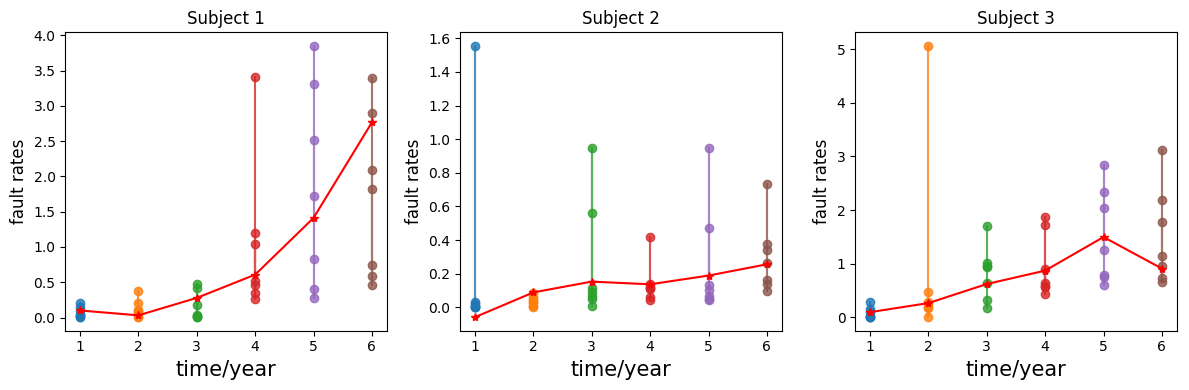

In [15]:
fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 3)
xipred = np.array(np.arange(6) + 1)

for ip in np.arange(3):
    ax = plt.subplot(gs[ip])
    xp = elec_year2[ip * 7:(ip + 1) * 7, :]  # 原始数据
    yp = elec_faults2[ip * 7:(ip + 1) * 7, :]
    ax.plot(xp, yp, marker='o', alpha=.8)

    yipred_yplot = np.array(Y_SVMpred[ip])#补上均值化的值

    ax.plot(xipred, yipred_yplot, 'k*-', color='r')
    plt.xlabel('time/year', fontsize=15)
    plt.ylabel('fault rates', fontsize=12)
    plt.title('Subject %s' % (ip + 1))

plt.tight_layout()
plt.show()

In [16]:
# 计算均方误差
RmseTrain_all_SVM = RMSE(elec_faults, Y_SVMpred, Len_One=6, Zoom_factor=100)
print(RmseTrain_all_SVM)

MseTrain_all_SVM = MSE(elec_faults, Y_SVMpred, Len_One=6, Zoom_factor=100)
print(MseTrain_all_SVM)

Rmse Mean is A、B、C :
{0: 0.009051929592089463, 1: 0.0024517477898557787, 2: 0.007763838717444187}
Mse Mean is A、B、C :
{0: 9.162696147836019e-05, 1: 0.00016179977612750473, 2: 8.388048977007011e-05}


In [17]:
# 第七年数据测试，读取测试数据集特征,
data_cs = pd.read_csv('XZ_CS.csv')
SNR_cs = np.random.normal(0, 2, size=[len(data_cs.Tem.values), 4])
datax_cs = np.array(data_cs)[:,0:4] + SNR_cs # 针对特征添加噪声

data_cs_year = data_cs.Year.values # 测试数据时间

meanVal = np.mean(datax_cs, axis=0)  # 按列求均值，即求各个特征的均值
newData_mean = datax_cs - meanVal
StdVal  = np.std(datax_cs, axis=0)
newData_std = newData_mean/StdVal


pca = PCA(n_components=2)
pca.fit(newData_std)
Pca_cs = pca.transform(newData_std) # 测试数据PCA特征值，直接调用即可，但是之调用这条也会出问题
Pca_cs_char1 = Pca_cs[:, 0]
Pca_cs_char2 = Pca_cs[:, 1]
print(data_cs_year)
print(len(data_cs_year))

[1 2 3 4 5 6 7 1 2 3 4 5 6 7 1 2 3 4 5 6 7 1 2 3 4 5 6 7 1 2 3 4 5 6 7 1 2
 3 4 5 6 7 1 2 3 4 5 6 7 1 2 3 4 5 6 7 1 2 3 4 5 6 7 1 2 3 4 5 6 7 1 2 3 4
 5 6 7 1 2 3 4 5 6 7 1 2 3 4 5 6 7 1 2 3 4 5 6 7 1 2 3 4 5 6 7 1 2 3 4 5 6
 7 1 2 3 4 5 6 7 1 2 3 4 5 6 7]
126


In [18]:
SVM_Pred = scale(np.vstack((data_cs_year, Pca_cs_char1, Pca_cs_char2)).T)

Pred_SVM_XZ = SVM_Pred[:42, :]
Pred_SVM_XJ = SVM_Pred[42:84, :]
Pred_SVM_HLJ = SVM_Pred[84:, :]


Pred_y_rbf_XZ = vr_rbf_XZ.fit(X_SVM_XZ, Y_SVM_XZ).predict(Pred_SVM_XZ)
print(len(Pred_y_rbf_XZ))
# print(Pred_y_rbf_XZ)
Pred_XZ_Mean = np.array([Pred_y_rbf_XZ[i*7:(i+1)*7] for i in np.arange(6)])
Pred_XZ_Mean1 = Pred_XZ_Mean.mean(axis=0)
print(Pred_XZ_Mean1)

Pred_y_rbf_XJ = vr_rbf_XJ.fit(X_SVM_XJ, Y_SVM_XJ).predict(Pred_SVM_XJ)
# print(Pred_y_rbf_XJ)
Pred_XJ_Mean = np.array([Pred_y_rbf_XJ[i*7:(i+1)*7] for i in np.arange(6)])
Pred_XJ_Mean1 = Pred_XJ_Mean.mean(axis=0)
print(Pred_XJ_Mean1)

Pred_y_rbf_HLJ = vr_rbf_HLJ.fit(X_SVM_HLJ, Y_SVM_HLJ).predict(Pred_SVM_HLJ)
# print(Pred_y_rbf_HLJ)
Pred_HLJ_Mean = np.array([Pred_y_rbf_HLJ[i*7:(i+1)*7] for i in np.arange(6)])
Pred_HLJ_Mean1 = Pred_HLJ_Mean.mean(axis=0)
print(Pred_HLJ_Mean1)

Pred_Y_SVMpred = np.vstack((Pred_XZ_Mean1, Pred_XJ_Mean1, Pred_HLJ_Mean1))# Pls预测值
print(Pred_Y_SVMpred)
# np.savetxt('Pred_Y_SVMpred.csv', Pred_Y_SVMpred, delimiter = ',')

42
[0. 0. 0. 0. 1. 2. 2.]
[-0.  0.  0.  0.  0.  0.  0.]
[0. 0. 0. 1. 1. 1. 1.]
[[ 0.  0.  0.  0.  1.  2.  2.]
 [-0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  1.  1.  1.]]


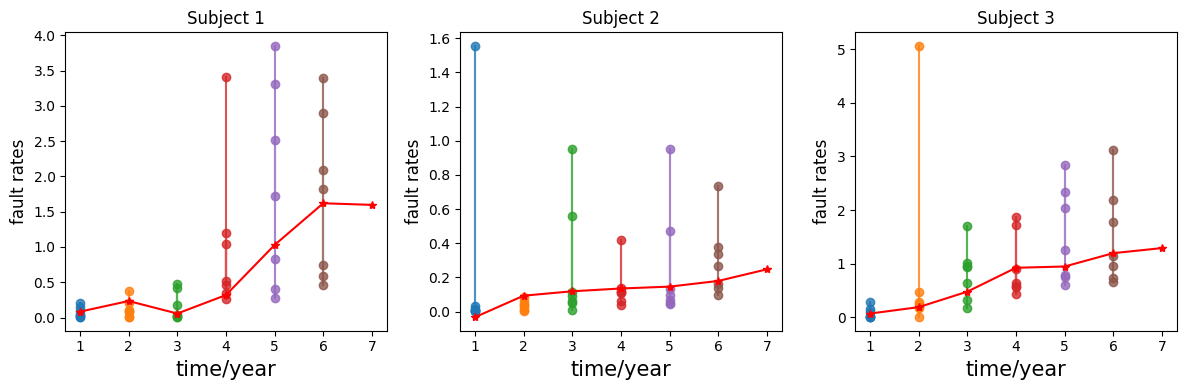

In [19]:
fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 3)
xipred = [1,2,3,4,5,6,7]

for ip in np.arange(3):
    ax = plt.subplot(gs[ip])
    xp = elec_year2[ip * 7:(ip + 1) * 7, :]  # 原始数据
    yp = elec_faults2[ip * 7:(ip + 1) * 7, :]
    ax.plot(xp, yp, marker='o', alpha=.8)

#     yipred_yplot = np.array(Pred_Y_SVMpred[ip])#补上均值化的值
    yipred_yplot = np.array(Pred_Y_SVMpred[ip])
    
    ax.plot(xipred, yipred_yplot[:], 'k*-', color='r')
    plt.xlabel('time/year', fontsize=15)
    plt.ylabel('fault rates', fontsize=12)
    plt.title('Subject %s' % (ip + 1))

plt.tight_layout()
plt.show()

In [20]:
# 计算预测的均方差
Pred7year_SVMA = Pred_Y_SVMpred[:,-1] #提取出ABC各省的均值预测值
print(Pred7year_SVMA)

Pred_Data = pd.read_csv('XZmulti_6_Only7Test.csv')
Pred_faults = 100 * (Pred_Data.Fault.values / Pred_Data.Nums.values)  # 数组形式,计算故障率大小

RmseTrain_svm = RMSEfor_Pred(Pred_faults, Pred7year_SVMA)
print(RmseTrain_svm)

[2. 0. 1.]
Rmse Mean is A、B、C :
{0: 0.015942244748250744, 1: 0.00233440435984919, 2: 0.00834479825945535}
